In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [7]:
# Load the datasets
# The datasets are expected to be in the same directory as the script
train_df = pd.read_csv('AssignmentTrain.csv')
test_df = pd.read_csv('AssignmentTest.csv')

In [8]:
null_values_train = train_df.isnull().sum()

# Printing the results
print("Null values in training dataset:\n", null_values_train)

Null values in training dataset:
 Product_id            0
Stall_no              5
instock_date          0
Market_Category       0
Customer_name       211
Loyalty_customer      0
Product_Category      0
Grade                 0
Demand                0
Discount_avail       38
charges_1           198
charges_2 (%)       205
Minimum_price        38
Maximum_price       343
Selling_Price        41
dtype: int64


In [10]:
# Data Preprocessing
# Handle missing values in the Selling_Price column and correct negative prices
train_df['Selling_Price'] = train_df['Selling_Price'].fillna(train_df['Selling_Price'].median()).abs()

In [12]:
# Identifying categorical and numerical columns
# Exclude 'Product_id' from categorical columns and 'Selling_Price' from numerical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.drop('Product_id')
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('Selling_Price')


In [19]:
# Preprocessors
# For numerical data: impute missing values with median and scale features
# For categorical data: impute missing values with the most frequent value and apply one-hot encoding
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

c:\Users\Yash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Yash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Yash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Yash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

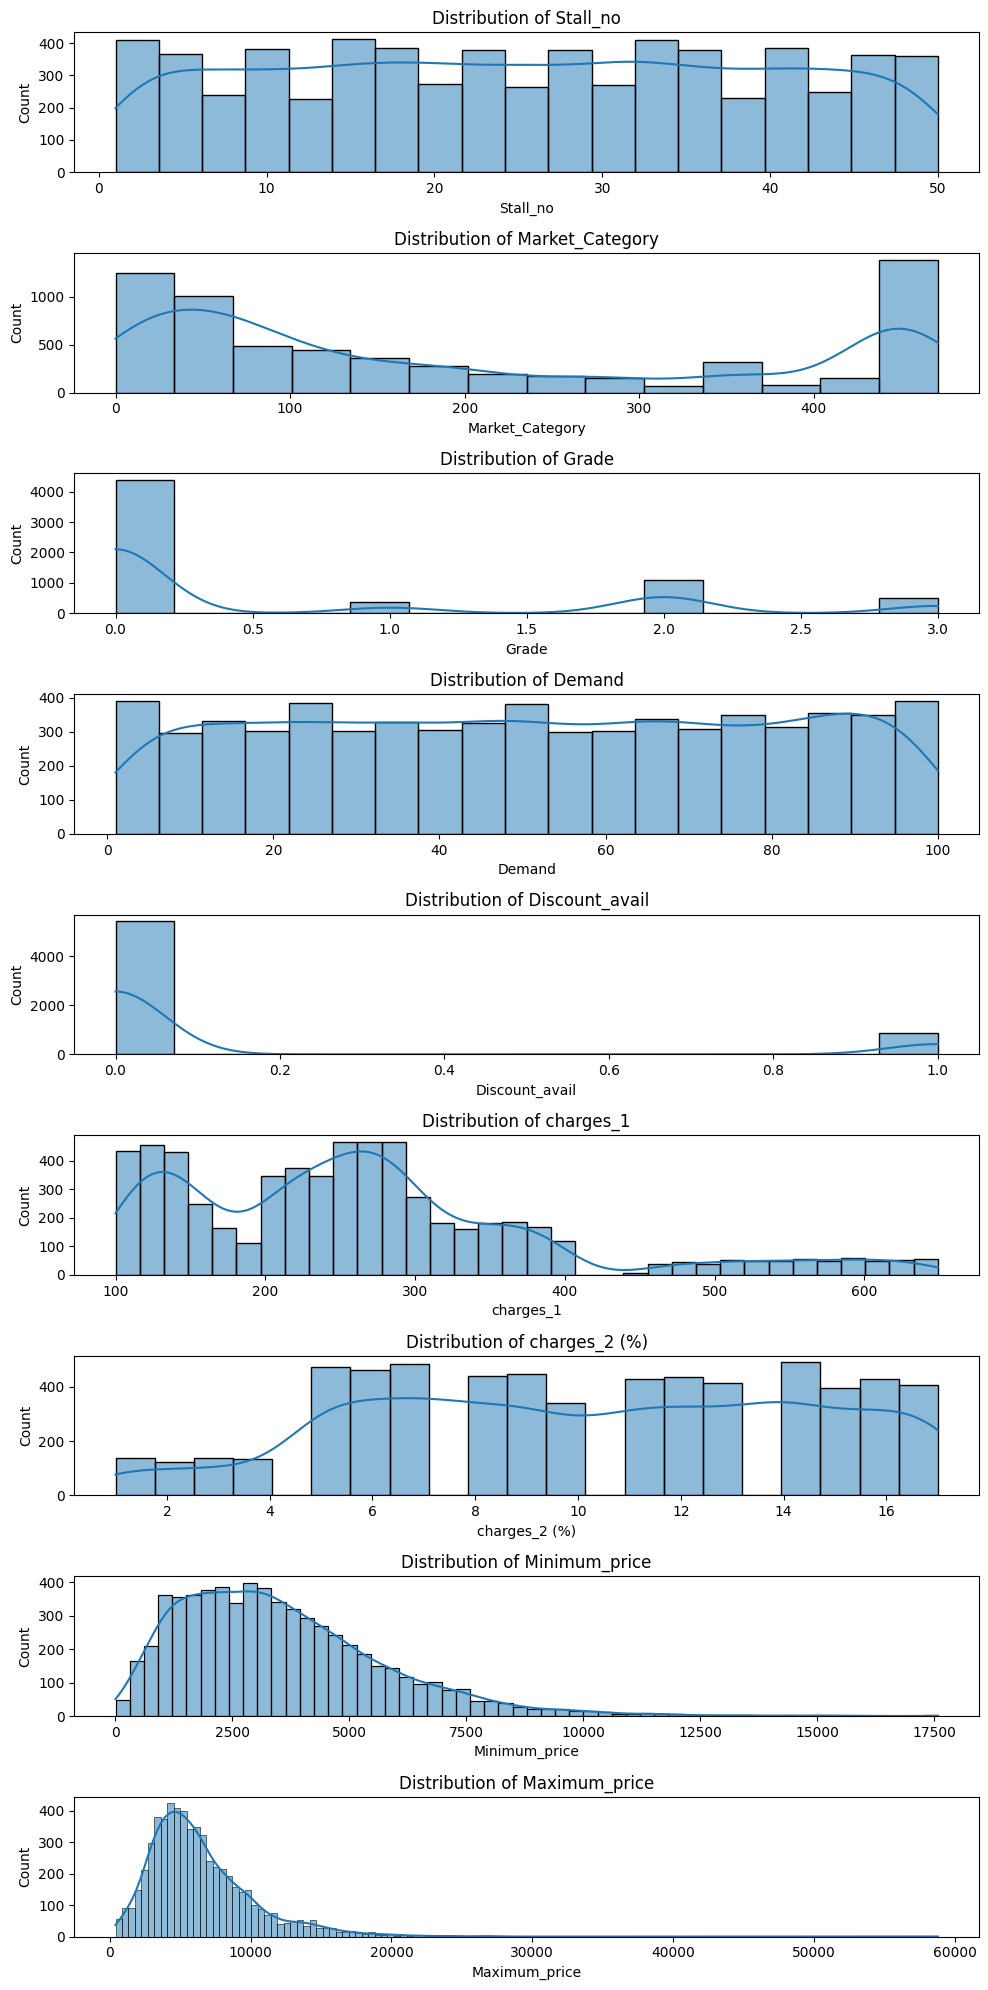

In [21]:
# Distribution of numerical features
fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(10, 20))
for i, col in enumerate(numerical_cols):
    if col != 'Selling_Price':  # Exclude Selling_Price from the distribution plots
        sns.histplot(train_df[col], ax=ax[i], kde=True)
        ax[i].set_title(f'Distribution of {col}')
plt.tight_layout()

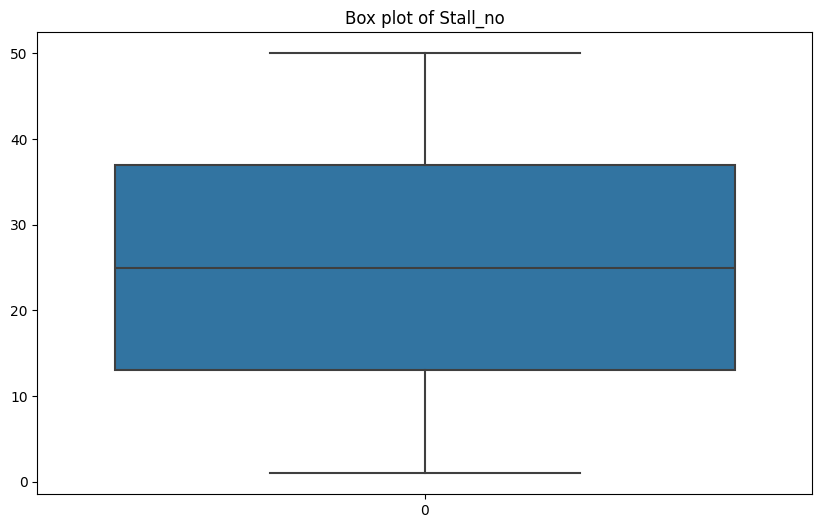

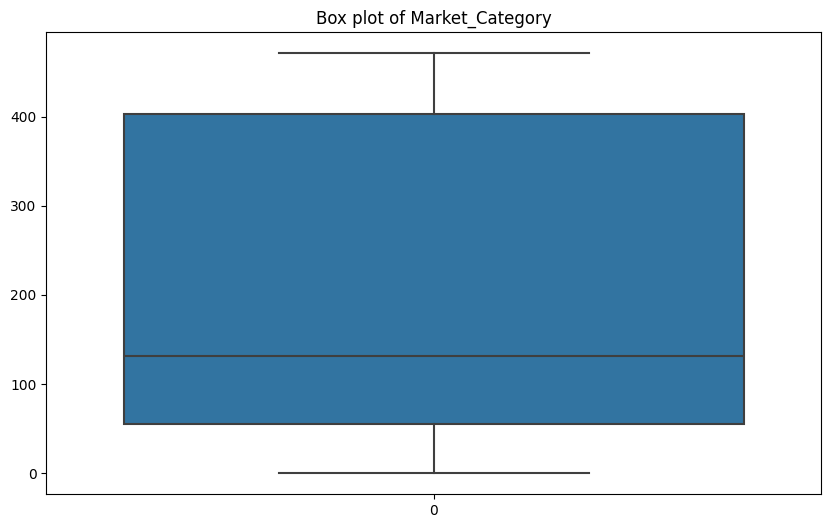

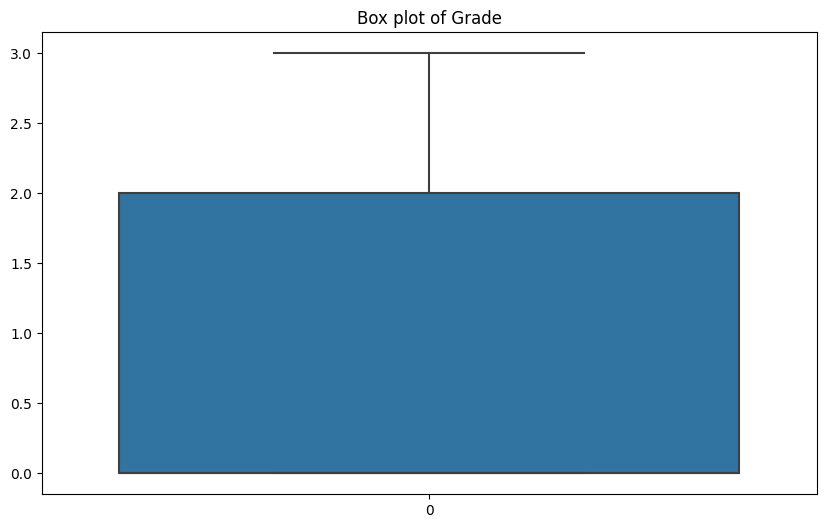

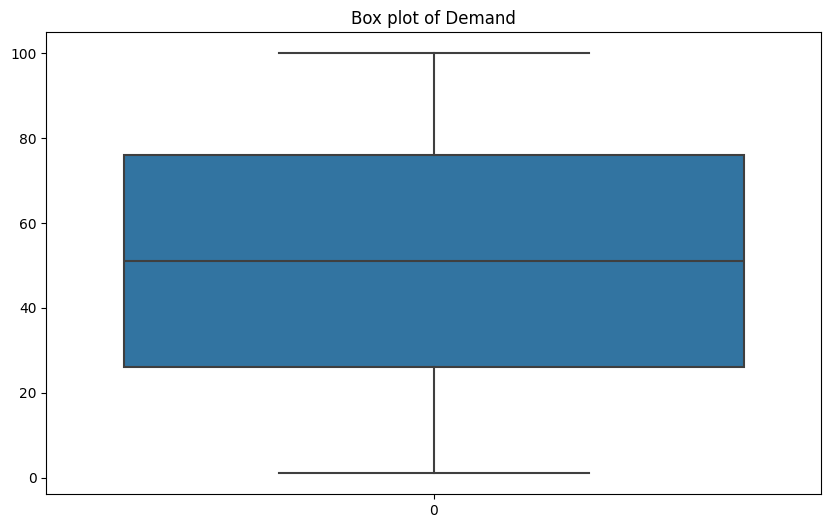

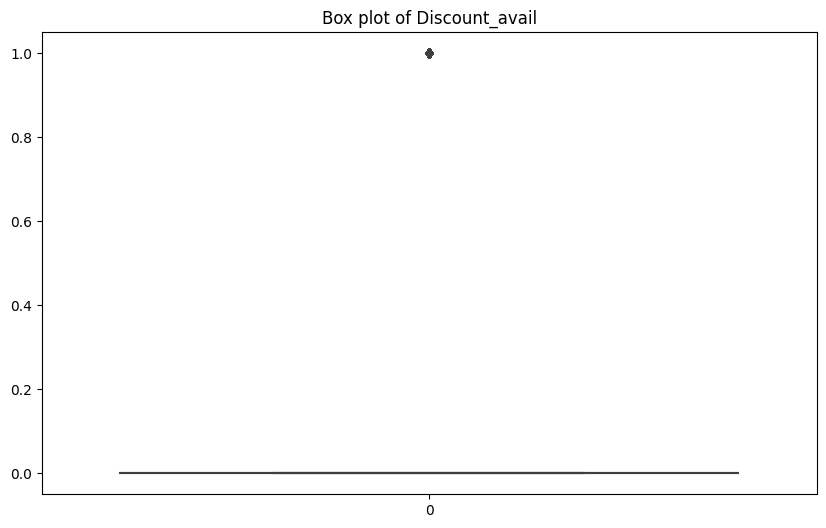

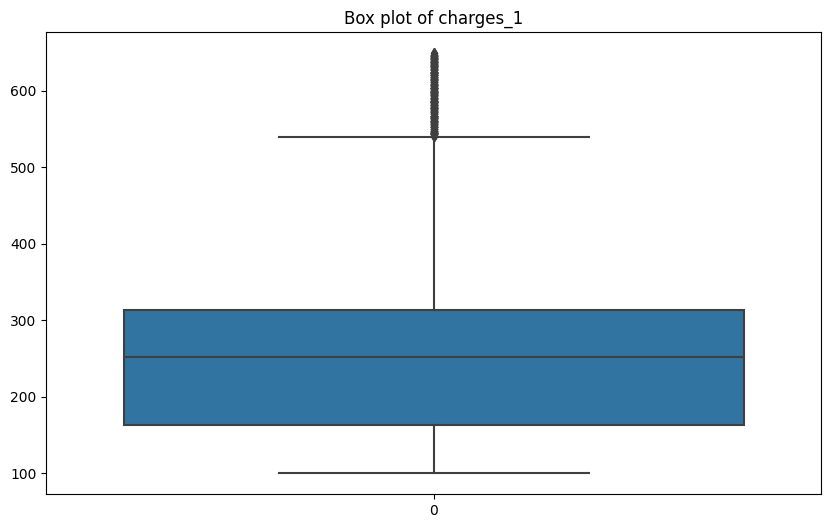

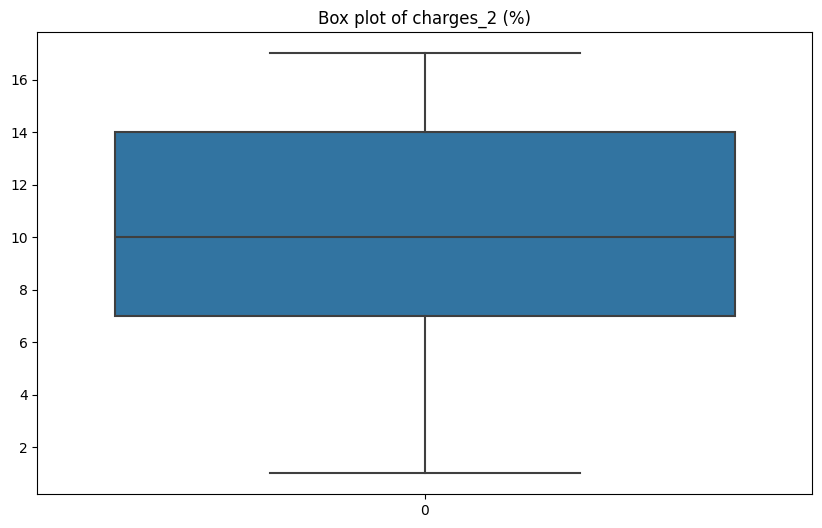

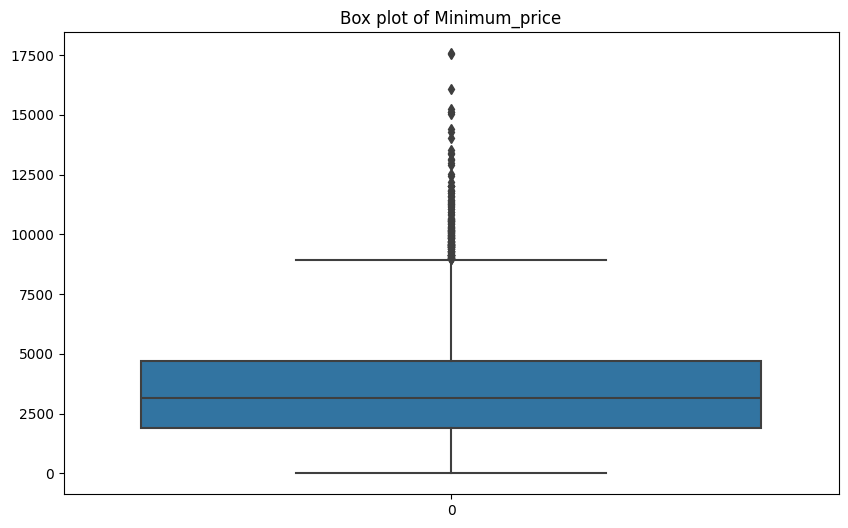

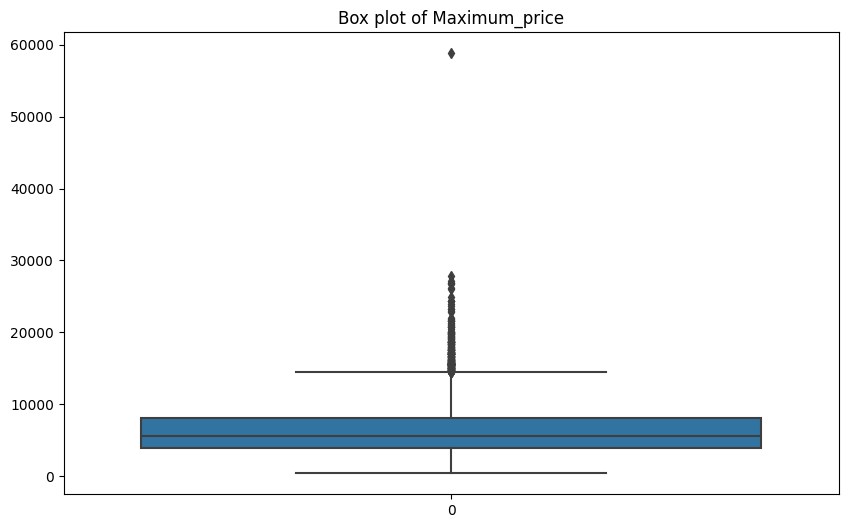

In [24]:
# Plotting box plots for numerical features
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_df[col].dropna())
    plt.title(f'Box plot of {col}')
    plt.show()

In [30]:
# Function to remove outliers
def remove_outliers(df, column):
    while True:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        initial_len = len(df)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        if initial_len == len(df) or len(df) < 0.5 * initial_len:
            break
    return df


In [31]:

# Removing outliers from specified columns
for col in ['charges_1', 'Minimum_price', 'Maximum_price']:
    train_df = remove_outliers(train_df, col)

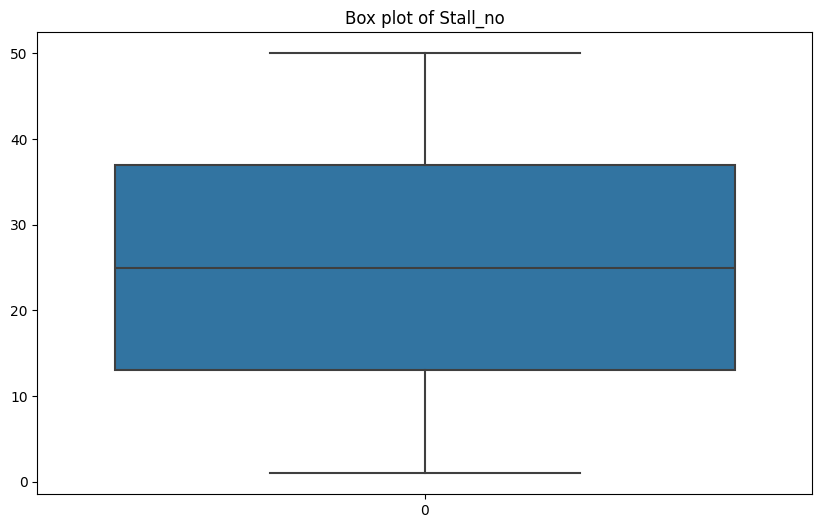

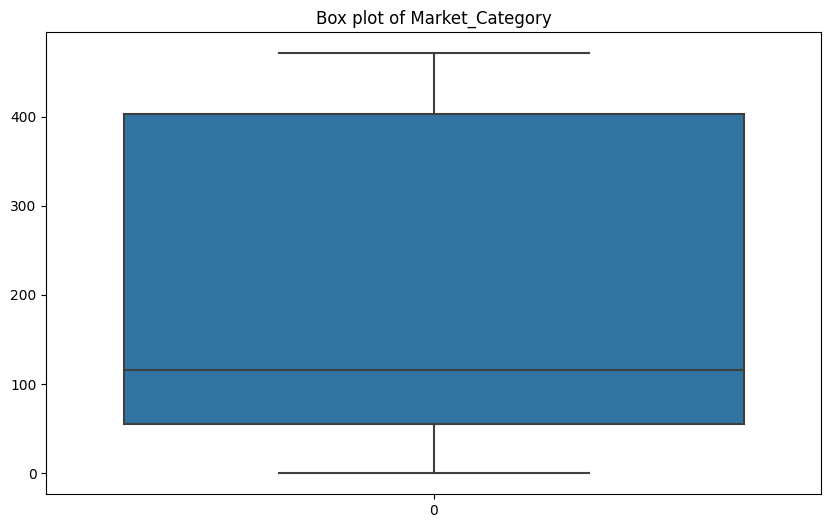

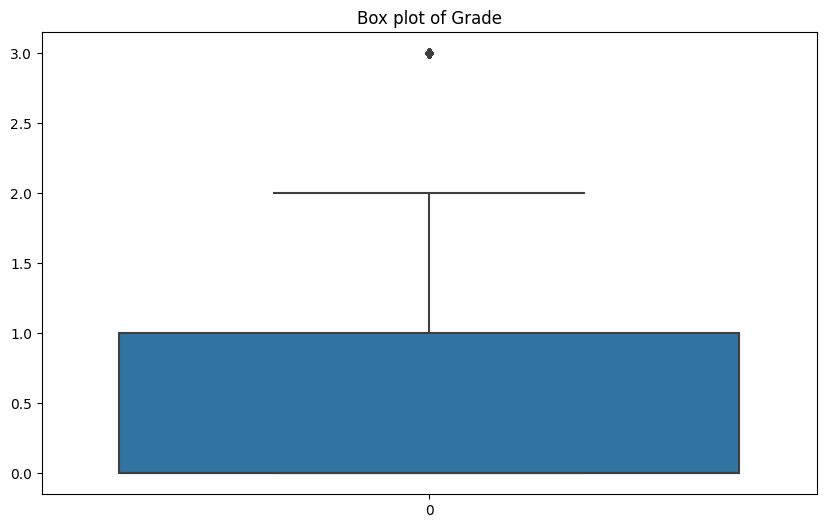

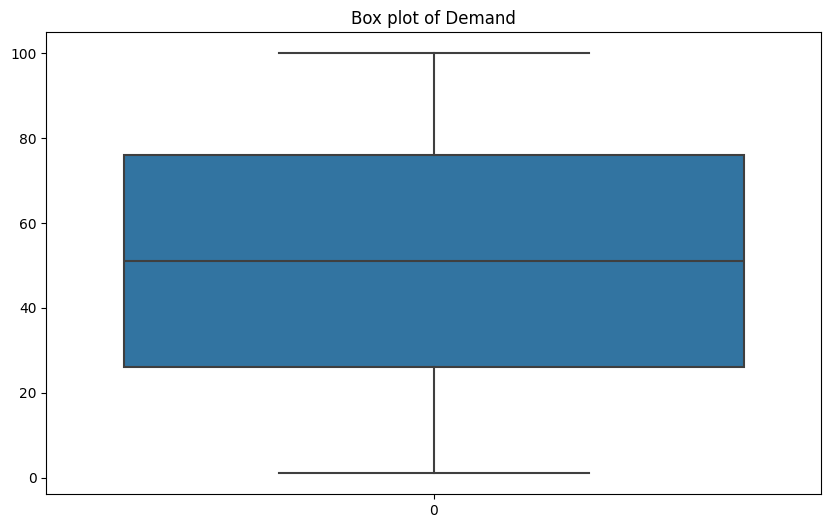

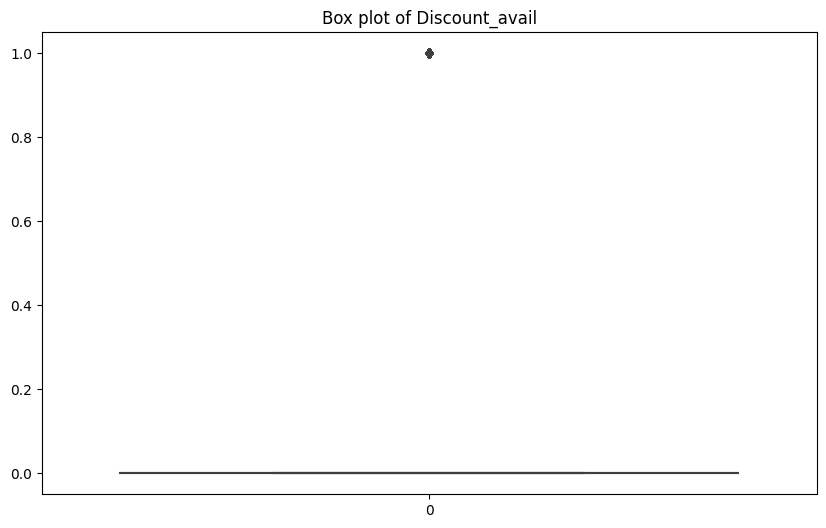

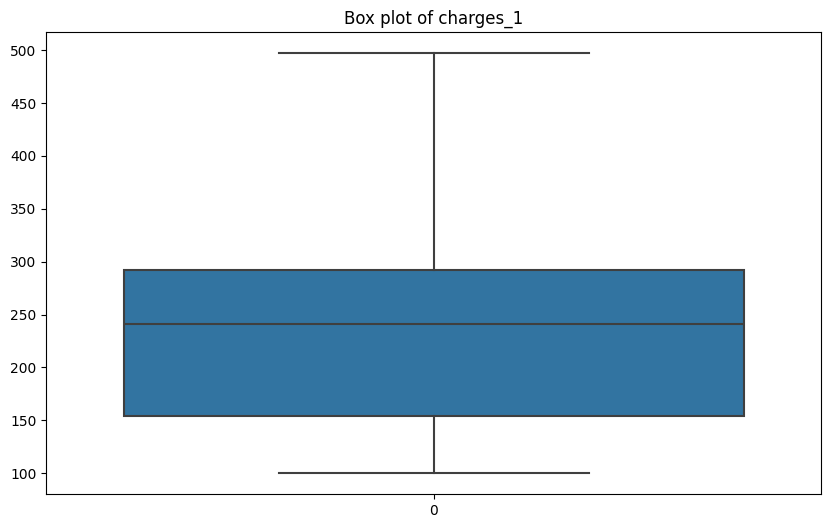

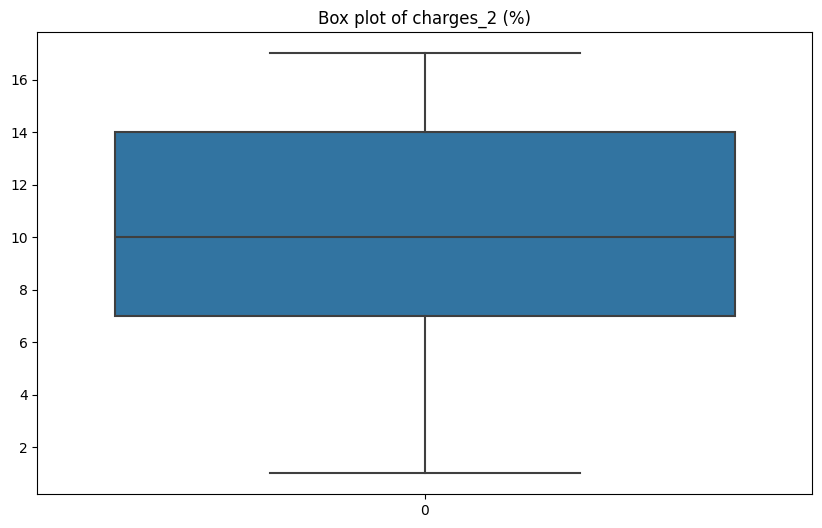

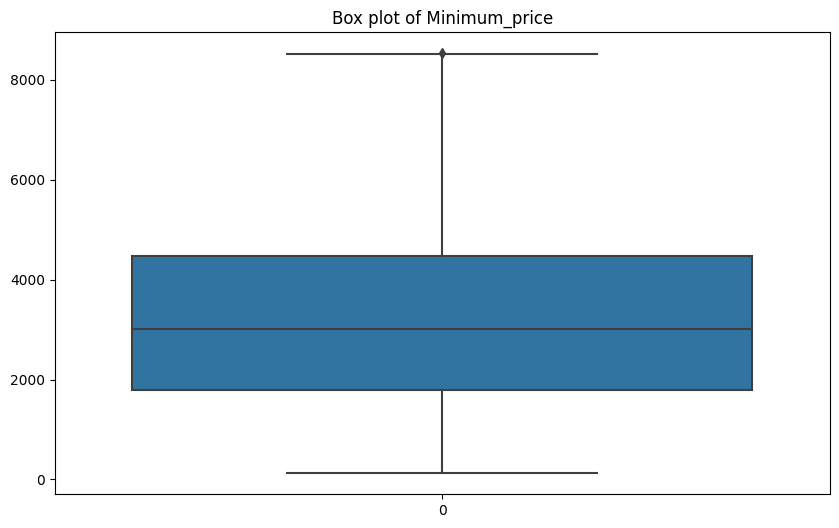

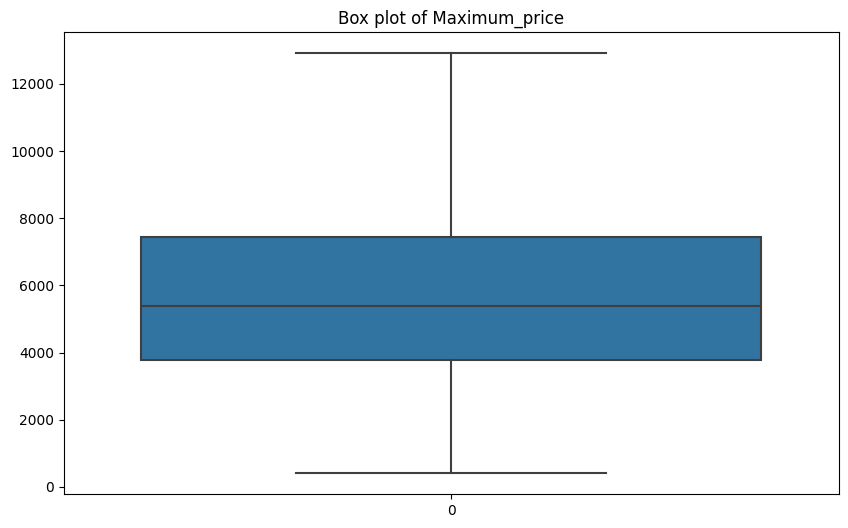

In [32]:
# Plotting box plots for numerical features
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_df[col].dropna())
    plt.title(f'Box plot of {col}')
    plt.show()

In [33]:
# Combining preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ])

In [34]:
# Model Pipeline
# Define the model pipeline with preprocessing and Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(random_state=42)
pipeline_gbr = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_gbr)])


In [35]:
# Parameter Grid for GridSearchCV
# Define a grid of hyperparameters to search over
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4]
}

In [36]:
# Setup the GridSearchCV
# Perform grid search with cross-validation to find the best parameters
grid_search = GridSearchCV(pipeline_gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


In [37]:
# Split the data into training and validation sets
X = train_df.drop(['Selling_Price', 'Product_id'], axis=1)
y = train_df['Selling_Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Stall_no', 'Market_Category', 'Grade', 'Demand', 'Discount_avail',
       'charges_1', 'charges_2 (%)', 'Minimum_price', 'Maximum_price'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeli...
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['instock_date', 'Customer_name', 'Loyalty_customer',
       'Product_Category'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 4],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [39]:
# Evaluate the model
# Use the best model to make predictions on the validation set and calculate accuracy metrics
y_pred = grid_search.predict(X_val)
r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

In [40]:
# Print accuracy metrics
print(f'R^2 Score: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

R^2 Score: 0.9851120695275125
Mean Squared Error: 81393.4855198662
Root Mean Squared Error: 285.29543550478724


In [41]:
# Predict on the test set
# Use the best model to predict the selling price on the test dataset
predictions = grid_search.predict(test_df.drop(['Product_id'], axis=1))


In [42]:
# Adjust negative predictions to zero
predictions_adjusted = np.where(predictions < 0, 0, predictions)

In [43]:
# Prepare the final submission file
final_submission_df = pd.DataFrame({'Product_id': test_df['Product_id'], 'Selling_Price': predictions_adjusted})
final_submission_df.to_csv('predicted_data.csv', index=False)


In [44]:

# Display the first few rows of the final submission file
print(final_submission_df.head())

         Product_id  Selling_Price
0  SCHE4YSTDVPVZVXW    3318.038887
1  ACCEGCATKHNRXUHW    1898.191867
2  NKCE6GJ5XVJDXNNZ   10209.452933
3  NKCEB8BK3ZXDHDHM    9056.047168
4  TOPEFDXSAHRNPF94    5617.279579
